In [ ]:
import sklearn
from sklearn.datasets import make_circles

samples=1000
x,y=make_circles(samples,noise=0.03,random_state=42)



In [ ]:
print(f"{x[:15]}")
print(f"{y[:15]}")

[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]
 [-0.47964637  0.67643477]
 [-0.01364836  0.80334872]
 [ 0.77151327  0.14775959]
 [-0.16932234 -0.79345575]
 [-0.1214858   1.02150905]
 [-0.64249042 -0.54409929]
 [ 0.5694666   0.84476776]
 [-0.11773591  0.83140071]
 [ 0.73410004 -0.33316553]
 [ 0.60077633 -0.58742632]]
[1 1 1 1 0 1 1 1 1 0 1 0 1 1 1]


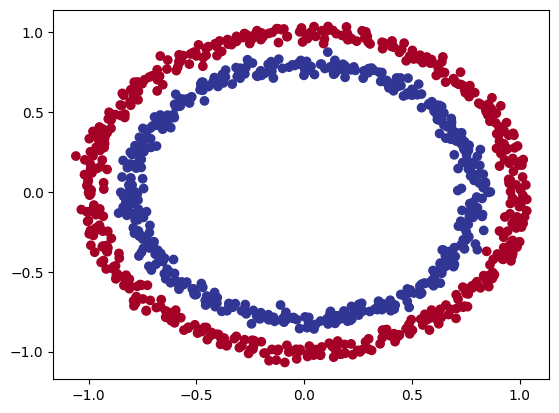

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(
    x=x[:,0],
    y=x[:,1],
    c=y,
    cmap= plt.cm.RdYlBu
)

In [ ]:
import torch
from torch import nn

In [ ]:
#turn data into tensors
xTensor = torch.from_numpy(x).type(torch.float)
yTensor = torch.from_numpy(y).type(torch.float)
xTensor

tensor([[ 0.7542,  0.2315],
        [-0.7562,  0.1533],
        [-0.8154,  0.1733],
        ...,
        [-0.1369, -0.8100],
        [ 0.6704, -0.7675],
        [ 0.2811,  0.9638]])

In [ ]:
#split data into test and train
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest = train_test_split(
    xTensor,
    yTensor,
    test_size=0.2,
    random_state=42
)


In [ ]:
len(xtrain),len(xtest),len(ytrain),len(ytest)

(800, 200, 800, 200)

In [ ]:
#building a model
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
class CircleModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(in_features=2,out_features=5)
    self.layer2 = nn.Linear(in_features=5,out_features=1)
  def forward(self,xTensor):
    return self.layer1(self.layer1(xTensor))# x > layer1 > layer2

model0=CircleModel().to(device)


In [ ]:
model0=nn.Sequential(
    nn.Linear(in_features=2,out_features=5),
    nn.Linear(in_features=5,out_features=1)
).to(device)
model0,model0.state_dict()

(Sequential(
   (0): Linear(in_features=2, out_features=5, bias=True)
   (1): Linear(in_features=5, out_features=1, bias=True)
 ),
 OrderedDict([('0.weight',
               tensor([[-0.0829, -0.2872],
                       [ 0.4691, -0.5582],
                       [-0.3260, -0.1997],
                       [-0.4252,  0.0667],
                       [-0.6984,  0.6386]], device='cuda:0')),
              ('0.bias',
               tensor([-0.6007,  0.5459,  0.1177, -0.2296,  0.4370], device='cuda:0')),
              ('1.weight',
               tensor([[ 0.0697,  0.3613,  0.0489, -0.1410,  0.1202]], device='cuda:0')),
              ('1.bias', tensor([-0.1213], device='cuda:0'))]))

In [ ]:
with torch.inference_mode():
  untrained_preds=model0(xtest.to(device))

print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(ytest)}, Shape: {ytest.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{ytest[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967],
        [ 0.2968],
        [ 0.1405],
        [ 0.2178],
        [ 0.0805],
        [-0.0284]], device='cuda:0')

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [ ]:
#loss and optimizer
lossfn=nn.BCEWithLogitsLoss()

optimizer=torch.optim.SGD(params=model0.parameters(),lr=0.1)

In [8]:
#calculate accuracy
def accuracyfn(ytrue,ypred):
  correct = torch.eq(ytrue,ypred).sum().item()
  acc=(correct/len(ypred))*100
  return acc

In [ ]:
#forward pass
#calculate loss
#optimize the zero grad
#backprop
#gradient descent

In [ ]:
model0.eval()
with torch.inference_mode():
  ylogits=model0(xtest.to(device))[0:5]
ylogits

tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967]], device='cuda:0')

In [ ]:
ypredprob=torch.sigmoid(ylogits)
ypredprob[0:5]

tensor([[0.4916],
        [0.4923],
        [0.5223],
        [0.4827],
        [0.5736]], device='cuda:0')

In [ ]:
torch.round(ypredprob),ytest[0:5]

(tensor([[0.],
         [0.],
         [1.],
         [0.],
         [1.]], device='cuda:0'),
 tensor([1., 0., 1., 0., 1.]))

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs=100

xtrain=xtrain.to(device)
ytrain=ytrain.to(device)
xtest=xtest.to(device)
ytest=ytest.to(device)

for epoch in range(epochs):
  #set training mode
  model0.train()

  #forward pass
  ylogits=model0(xtrain).squeeze()
  ypred=torch.round(torch.sigmoid(ylogits))

  #calculate the loss
  loss = lossfn(ylogits,ytrain)
  acc=accuracyfn(ytrain,ypred)

  #optimize zero grad
  optimizer.zero_grad()

  #loss backward
  loss.backward()

  #optimizer step
  optimizer.step()

  #test
  model0.eval()
  with torch.inference_mode():
    testlogits = model0(xtest).squeeze()
    testpred = torch.round(torch.sigmoid(testlogits))

    testloss=lossfn(testlogits,ytest)
    testacc = accuracyfn(ytest,testpred)
  if epoch%10==0:
    print(f"epoch :{epoch:.2f} | loss :{loss:.2f} | acc :{acc:.2f}% | test loss :{testloss:.2f} | test acc :{testacc:.2f}%")

epoch :0.00 | loss :0.70 | acc :51.88% | test loss :0.69 | test acc :58.00%
epoch :10.00 | loss :0.70 | acc :51.25% | test loss :0.69 | test acc :53.00%
epoch :20.00 | loss :0.69 | acc :51.62% | test loss :0.69 | test acc :49.50%
epoch :30.00 | loss :0.69 | acc :51.12% | test loss :0.69 | test acc :49.50%
epoch :40.00 | loss :0.69 | acc :50.88% | test loss :0.69 | test acc :51.00%
epoch :50.00 | loss :0.69 | acc :50.25% | test loss :0.69 | test acc :50.00%
epoch :60.00 | loss :0.69 | acc :50.00% | test loss :0.69 | test acc :51.50%
epoch :70.00 | loss :0.69 | acc :50.25% | test loss :0.69 | test acc :51.00%
epoch :80.00 | loss :0.69 | acc :49.88% | test loss :0.69 | test acc :50.00%
epoch :90.00 | loss :0.69 | acc :49.88% | test loss :0.69 | test acc :53.00%


In [ ]:
!pip install pathlib

In [ ]:
import requests
from pathlib import Path

if( Path("helper_functions.py").is_file() ):
  print("file available no download")
else:
  print("dowloading")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

dowloading


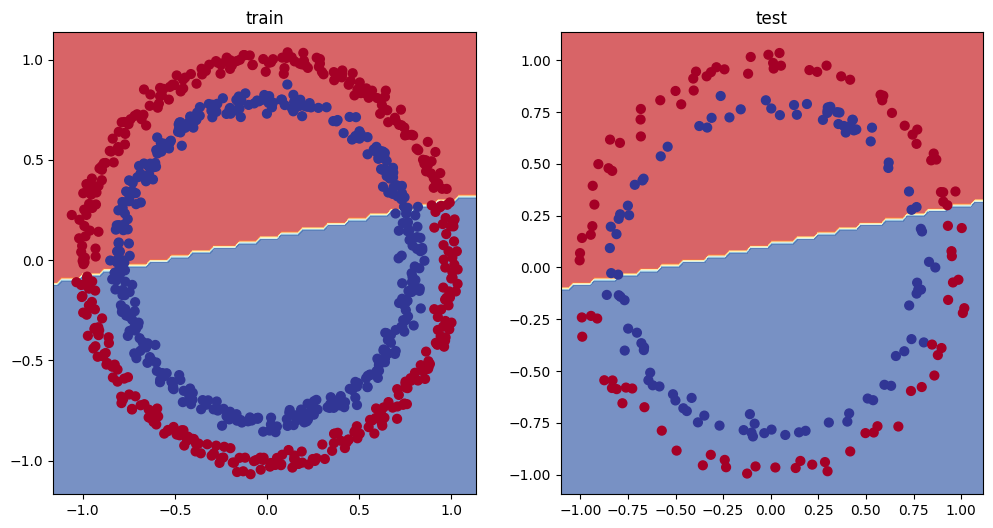

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("train")
plot_decision_boundary(model0,xtrain,ytrain)
plt.subplot(1,2,2)
plt.title("test")
plot_decision_boundary(model0,xtest,ytest)

In [ ]:
import torch
from torch import nn
device = "cuda" if torch.cuda.is_available() else "cpu"
#improving the bad model
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(in_features=2,out_features=10)
    self.layer2 = nn.Linear(in_features=10,out_features=10)
    self.layer3 = nn.Linear(in_features=10,out_features=1)
  def forward(self ,x):
    return self.layer3(self.layer2(self.layer1(x)))


model1=CircleModelV2().to(device)

In [ ]:
device

'cuda'

In [ ]:
#loss and optimizer
lossfn=nn.BCEWithLogitsLoss()

optimizer=torch.optim.SGD(params=model1.parameters(),lr=0.01)

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs=1000

xtrain=xtrain.to(device)
ytrain=ytrain.to(device)
xtest=xtest.to(device)
ytest=ytest.to(device)

for epoch in range(epochs):
  #set training mode
  model1.train()

  #forward pass
  ylogits=model1(xtrain).squeeze()
  ypred=torch.round(torch.sigmoid(ylogits))

  #calculate the loss
  loss = lossfn(ylogits,ytrain)
  acc=accuracyfn(ytrain,ypred)

  #optimize zero grad
  optimizer.zero_grad()

  #loss backward
  loss.backward()

  #optimizer step
  optimizer.step()

  #test
  model1.eval()
  with torch.inference_mode():
    testlogits = model1(xtest).squeeze()
    testpred = torch.round(torch.sigmoid(testlogits))

    testloss=lossfn(testlogits,ytest)
    testacc = accuracyfn(ytest,testpred)
  if epoch%100==0:
    print(f"epoch :{epoch:.2f} | loss :{loss:.2f} | acc :{acc:.2f}% | test loss :{testloss:.2f} | test acc :{testacc:.2f}%")

epoch :0.00 | loss :0.69 | acc :50.88% | test loss :0.69 | test acc :51.00%
epoch :100.00 | loss :0.69 | acc :50.25% | test loss :0.69 | test acc :50.00%
epoch :200.00 | loss :0.69 | acc :50.12% | test loss :0.69 | test acc :49.50%
epoch :300.00 | loss :0.69 | acc :50.50% | test loss :0.69 | test acc :49.00%
epoch :400.00 | loss :0.69 | acc :50.38% | test loss :0.69 | test acc :48.50%
epoch :500.00 | loss :0.69 | acc :49.88% | test loss :0.69 | test acc :49.50%
epoch :600.00 | loss :0.69 | acc :49.50% | test loss :0.69 | test acc :53.00%
epoch :700.00 | loss :0.69 | acc :49.38% | test loss :0.69 | test acc :50.50%
epoch :800.00 | loss :0.69 | acc :50.00% | test loss :0.69 | test acc :51.00%
epoch :900.00 | loss :0.69 | acc :50.62% | test loss :0.69 | test acc :47.50%


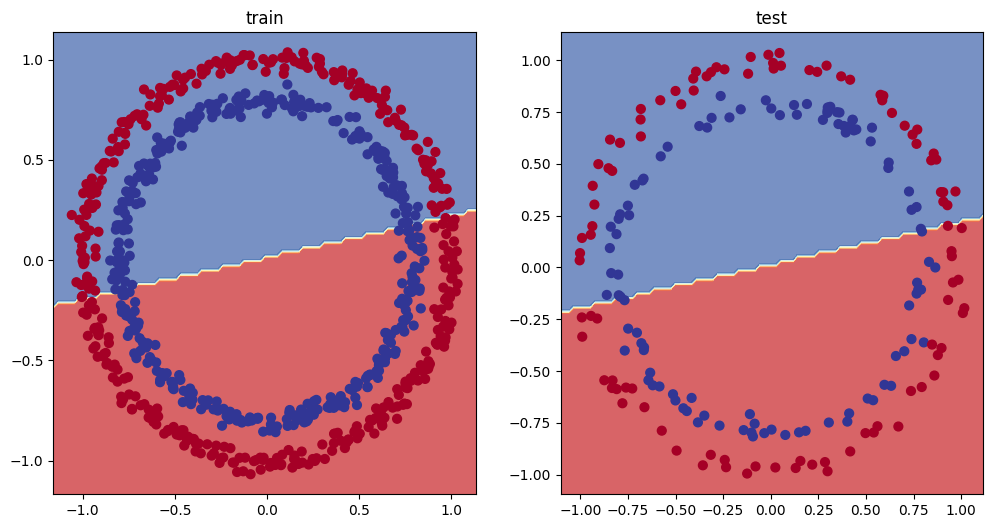

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("train")
plot_decision_boundary(model1,xtrain,ytrain)
plt.subplot(1,2,2)
plt.title("test")
plot_decision_boundary(model1,xtest,ytest)

In [ ]:
import sklearn
from sklearn.datasets import make_circles

samples=1000
x,y=make_circles(samples,noise=0.03,random_state=42)



In [ ]:
print(f"{x[:15]}")
print(f"{y[:15]}")

[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]
 [-0.47964637  0.67643477]
 [-0.01364836  0.80334872]
 [ 0.77151327  0.14775959]
 [-0.16932234 -0.79345575]
 [-0.1214858   1.02150905]
 [-0.64249042 -0.54409929]
 [ 0.5694666   0.84476776]
 [-0.11773591  0.83140071]
 [ 0.73410004 -0.33316553]
 [ 0.60077633 -0.58742632]]
[1 1 1 1 0 1 1 1 1 0 1 0 1 1 1]


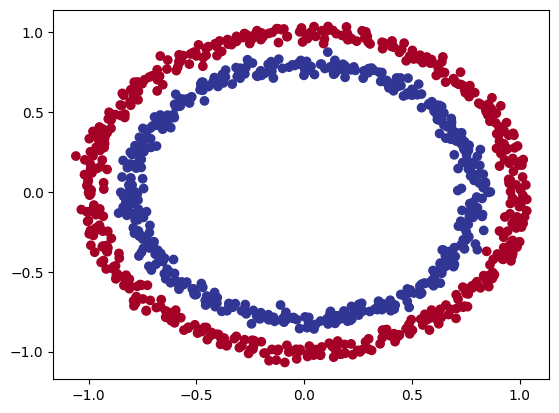

In [ ]:
import sklearn
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt

samples=1000
x,y=make_circles(samples,noise=0.03,random_state=42)



plt.scatter(
    x=x[:,0],
    y=x[:,1],
    c=y,
    cmap= plt.cm.RdYlBu
)

import torch
from sklearn.model_selection import train_test_split
import numpy as np





x = torch.from_numpy(x).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
xtrain,xtest,ytrain,ytest=train_test_split(n,y,test_size=0.2,random_state=42)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
from torch import nn
class Circlemodelv3(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1=nn.Linear(in_features=2,out_features=10)
    self.layer2=nn.Linear(in_features=10,out_features=10)
    self.layer3=nn.Linear(in_features=10,out_features=1)
    self.relu = nn.ReLU()

  def forward(self,x):
    return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))

model3=Circlemodelv3().to(device)
model3

Circlemodelv3(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
#loss and optimizer
lossfn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model3.parameters(),lr=0.1)

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs=1000

xtrain=xtrain.to(device)
ytrain=ytrain.to(device)
xtest=xtest.to(device)
ytest=ytest.to(device)

for epoch in range(epochs):
  #set training mode
  model3.train()

  #forward pass
  ylogits=model3(xtrain).squeeze()
  ypred=torch.round(torch.sigmoid(ylogits))

  #calculate the loss
  loss = lossfn(ylogits,ytrain)
  acc=accuracyfn(ytrain,ypred)

  #optimize zero grad
  optimizer.zero_grad()

  #loss backward
  loss.backward()

  #optimizer step
  optimizer.step()

  #test
  model3.eval()
  with torch.inference_mode():
    testlogits = model3(xtest).squeeze()
    testpred = torch.round(torch.sigmoid(testlogits))

    testloss=lossfn(testlogits,ytest)
    testacc = accuracyfn(ytest,testpred)
  if epoch%100==0:
    print(f"epoch :{epoch:.2f} | loss :{loss:.2f} | acc :{acc:.2f}% | test loss :{testloss:.2f} | test acc :{testacc:.2f}%")

epoch :0.00 | loss :0.07 | acc :99.88% | test loss :0.10 | test acc :99.50%
epoch :100.00 | loss :0.07 | acc :99.88% | test loss :0.10 | test acc :99.50%
epoch :200.00 | loss :0.07 | acc :99.88% | test loss :0.10 | test acc :99.50%
epoch :300.00 | loss :0.07 | acc :99.88% | test loss :0.10 | test acc :99.50%
epoch :400.00 | loss :0.06 | acc :99.88% | test loss :0.10 | test acc :99.50%
epoch :500.00 | loss :0.06 | acc :99.88% | test loss :0.09 | test acc :99.50%
epoch :600.00 | loss :0.06 | acc :99.88% | test loss :0.09 | test acc :99.50%
epoch :700.00 | loss :0.06 | acc :99.88% | test loss :0.09 | test acc :99.50%
epoch :800.00 | loss :0.06 | acc :99.88% | test loss :0.09 | test acc :99.50%
epoch :900.00 | loss :0.06 | acc :99.88% | test loss :0.09 | test acc :99.50%


file available download skipped


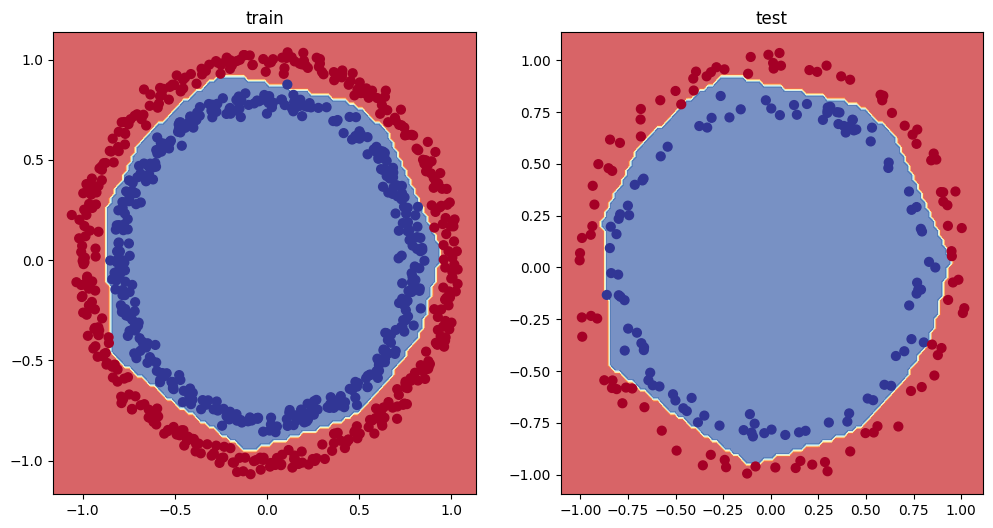

In [ ]:
import requests
from pathlib import Path

if( Path("helper_functions.py").is_file() ):
  print("file available download skipped")
else:
  print("dowloading")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("train")
plot_decision_boundary(model3,xtrain,ytrain)
plt.subplot(1,2,2)
plt.title("test")
plot_decision_boundary(model3,xtest,ytest)

In [ ]:
#multiclass classification


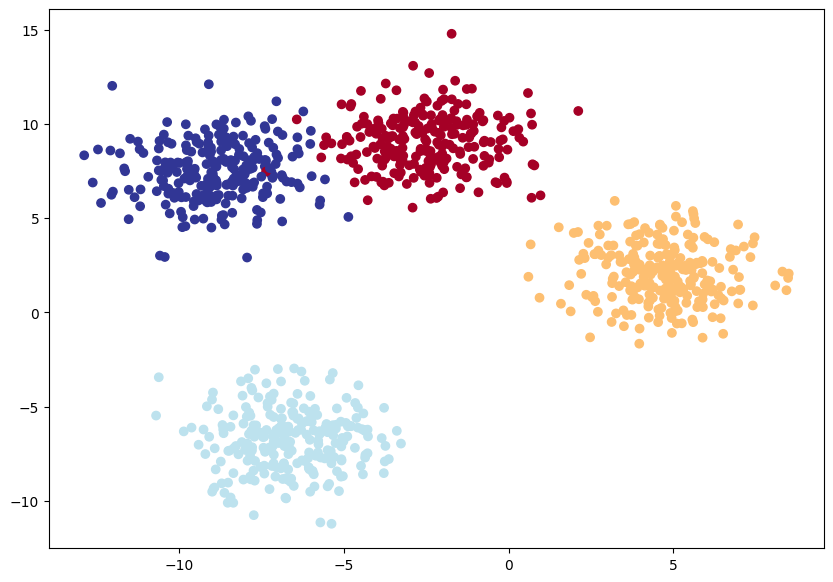

In [13]:
#creating a toy dataset
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

NUM_CLASSES=4
NUM_FEATURES=2
RANDOM_SEED=42

xblob,yblob=make_blobs(n_samples=1000,n_features=NUM_FEATURES,centers=NUM_CLASSES,random_state=RANDOM_SEED,cluster_std=1.5)#,

#data into tensors
xblob=torch.from_numpy(xblob).type(torch.float)
yblob=torch.from_numpy(yblob).type(torch.LongTensor)

#split into train and test
xtrain,xtest,ytrain,ytest = train_test_split(xblob,yblob,test_size=0.2,random_state=RANDOM_SEED)

#plot the data
plt.figure(figsize=(10,7))
plt.scatter(xblob[:,0],xblob[:,1],c=yblob,cmap=plt.cm.RdYlBu)


In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"
from torch import nn
print(device)

class BlobModel(nn.Module):
  def __init__(self,input_features,output_features,hidden_units=8):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features,out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,out_features=output_features)
    )
  def forward(self, x):
    return self.linear_layer_stack(x)


model4 = BlobModel(input_features=2,output_features=4,hidden_units=8).to(device)

cpu


In [15]:
#loss function and optimizer
lossfn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model4.parameters(),lr=0.1)

In [18]:
#create a training and testing loop

def accuracyfn(ytrue,ypred):
  correct = torch.eq(ytrue,ypred).sum().item()
  acc=(correct/len(ypred))*100
  return acc


torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs=100

xtrain=xtrain.to(device)
ytrain=ytrain.to(device)
xtest=xtest.to(device)
ytest=ytest.to(device)

for epoch in range(epochs):
  #set training mode
  model4.train()

  #forward pass
  ylogits=model4(xtrain).squeeze()
  ypred=torch.softmax(ylogits,dim=1).argmax(dim=1)

  #calculate the loss
  loss = lossfn(ylogits,ytrain)
  acc=accuracyfn(ytrain,ypred)

  #optimize zero grad
  optimizer.zero_grad()

  #loss backward
  loss.backward()

  #optimizer step
  optimizer.step()

  #test
  model4.eval()
  with torch.inference_mode():
    testlogits = model4(xtest).squeeze()
    testpred = torch.softmax(testlogits,dim=1).argmax(dim=1)

    testloss=lossfn(testlogits,ytest)
    testacc = accuracyfn(ytest,testpred)
  if epoch%10==0:
    print(f"epoch :{epoch:.2f} | loss :{loss:.2f} | acc :{acc:.2f}% | test loss :{testloss:.2f} | test acc :{testacc:.2f}%")

epoch :0.00 | loss :0.03 | acc :99.25% | test loss :0.02 | test acc :99.50%
epoch :10.00 | loss :0.03 | acc :99.25% | test loss :0.02 | test acc :99.50%
epoch :20.00 | loss :0.03 | acc :99.25% | test loss :0.02 | test acc :99.50%
epoch :30.00 | loss :0.03 | acc :99.25% | test loss :0.02 | test acc :99.50%
epoch :40.00 | loss :0.03 | acc :99.25% | test loss :0.02 | test acc :99.50%
epoch :50.00 | loss :0.03 | acc :99.25% | test loss :0.02 | test acc :99.50%
epoch :60.00 | loss :0.03 | acc :99.25% | test loss :0.02 | test acc :99.50%
epoch :70.00 | loss :0.03 | acc :99.25% | test loss :0.02 | test acc :99.50%
epoch :80.00 | loss :0.03 | acc :99.25% | test loss :0.02 | test acc :99.50%
epoch :90.00 | loss :0.03 | acc :99.25% | test loss :0.02 | test acc :99.50%


In [20]:
#make predictions
model4.eval()
with torch.inference_mode():
  ylogits=model4(xtest)

ylogits[:10]

tensor([[ -0.8275,   7.4320,  -8.6558,  -9.6514],
        [ -2.4389,  -7.2588,  -4.4828,   4.0251],
        [ -4.1976,  -4.6293,   3.9776,  -3.1901],
        [ -1.4920,   5.2994,  -4.4653,  -5.5549],
        [  4.8249,  -1.4429, -10.3200,  -8.0009],
        [ -3.1223,  -8.6489,  -5.1848,   4.7896],
        [ -3.7167,  -3.9705,   3.5040,  -2.6376],
        [  4.3045,  -4.6910,  -7.8507,  -4.0628],
        [ -5.3417,  -5.9122,   4.8492,  -4.1046],
        [  4.4872,  -3.4761,  -8.5520,  -5.3956]])

In [21]:
ypredprob=torch.softmax(ylogits,dim=1)
ypredprob[:10]

tensor([[2.5871e-04, 9.9974e-01, 1.0305e-07, 3.8076e-08],
        [1.5557e-03, 1.2551e-05, 2.0150e-04, 9.9823e-01],
        [2.8122e-04, 1.8262e-04, 9.9877e-01, 7.7016e-04],
        [1.1221e-03, 9.9880e-01, 5.7378e-05, 1.9299e-05],
        [9.9810e-01, 1.8928e-03, 2.6414e-07, 2.6854e-06],
        [3.6619e-04, 1.4573e-06, 4.6555e-05, 9.9959e-01],
        [7.2878e-04, 5.6543e-04, 9.9656e-01, 2.1440e-03],
        [9.9964e-01, 1.2392e-04, 5.2590e-06, 2.3226e-04],
        [3.7502e-05, 2.1198e-05, 9.9981e-01, 1.2922e-04],
        [9.9960e-01, 3.4786e-04, 2.1726e-06, 5.1023e-05]])

In [23]:
ypreds=torch.argmax(ypredprob,dim=1)
print(ypreds[:10])
print(ytest[:10])

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])


dowloading


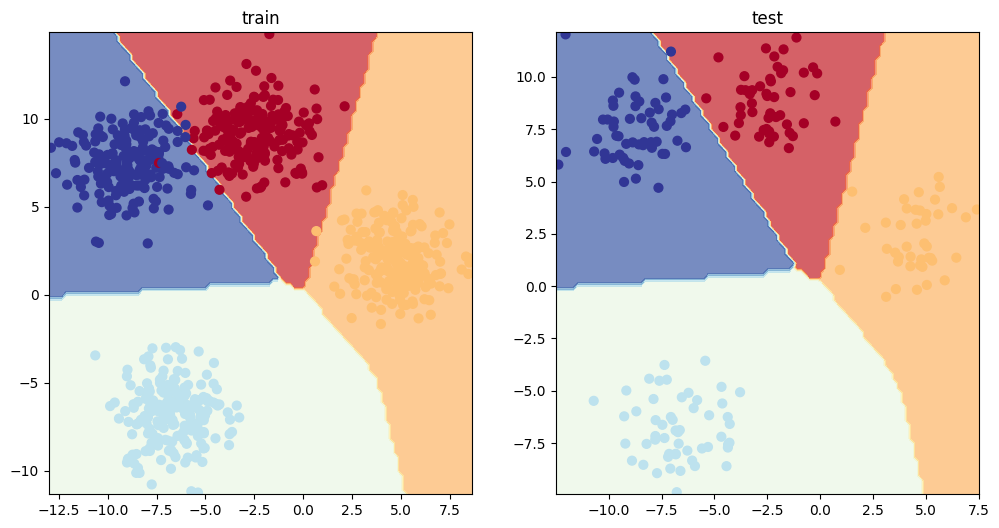

In [24]:
import requests
from pathlib import Path

if( Path("helper_functions.py").is_file() ):
  print("file available download skipped")
else:
  print("dowloading")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("train")
plot_decision_boundary(model4,xtrain,ytrain)
plt.subplot(1,2,2)
plt.title("test")
plot_decision_boundary(model4,xtest,ytest)

In [25]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 46.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 54.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 56.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [27]:
from torchmetrics import Accuracy

torchmetric_accuracy=Accuracy(task="multiclass", num_classes=4).to(device)

torchmetric_accuracy(ypreds,ytest)

tensor(0.9950)